In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from P5_functions import *
from P4_functions import *
from sklearn.model_selection import train_test_split
from collections import deque
import pickle
from sklearn.model_selection import GridSearchCV
from numpy import random

In [2]:
def visualize_from_path(fig, rows, cols, img_paths, titles):
    for i, img_path in enumerate(img_paths):
        img = mpimg.imread(img_path)
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img,cmap='hot')            
        else:
            plt.imshow(img)
        if (isinstance(titles, str)):
            plt.title(titles)
        else:
            plt.title(titles[i])
            
def visualize_from_img(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img,cmap='hot')            
        else:
            plt.imshow(img)
        if (isinstance(titles, str)):
            plt.title(titles)
        else:
            plt.title(titles[i])
            



Car Images > img/vehicles/GTI_Far/*
Car Images > img/vehicles/GTI_Left/*
Car Images > img/vehicles/GTI_MiddleClose/*
Car Images > img/vehicles/GTI_Right/*
Car Images > img/vehicles/KITTI_extracted/*
Not Car Images > img/non-vehicles/Extras/*
Not Car Images > img/non-vehicles/GTI/*
Total car images: 8792
Total not car images: 8968


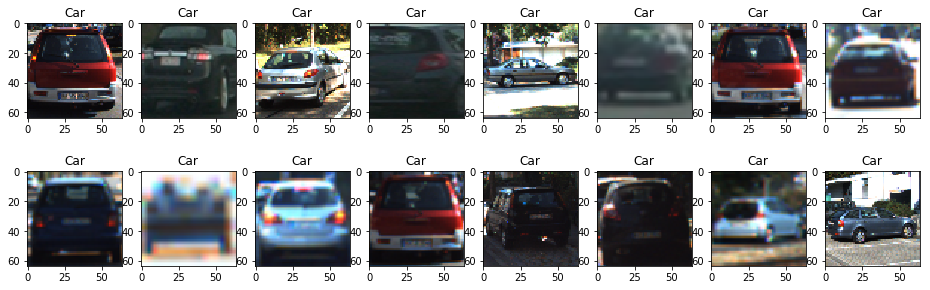

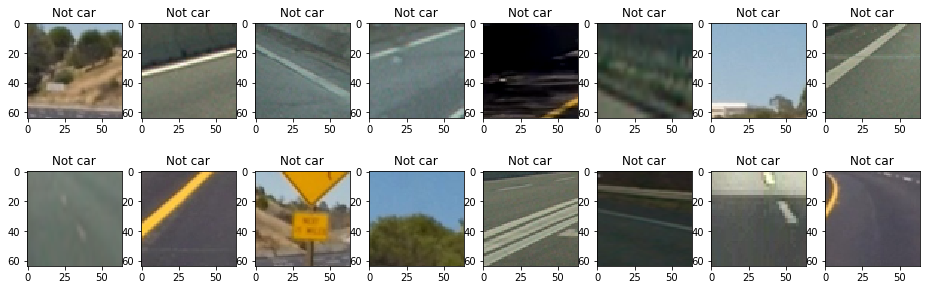

In [3]:
writeImagesOut = True
basedir = "img/vehicles/"
sub_folders = os.listdir(basedir)
cars = []
for sub_folder in sub_folders:
    print("Car Images > " + basedir + sub_folder + "/*")
    cars.extend(glob.glob(basedir + sub_folder + "/*"))

basedir = "img/non-vehicles/"
sub_folders = os.listdir(basedir)
notcars = []
for sub_folder in sub_folders:
    print("Not Car Images > " + basedir + sub_folder + "/*")
    notcars.extend(glob.glob(basedir + sub_folder + "/*"))

print('Total car images: ' + str(len(cars)))
print('Total not car images: ' + str(len(notcars)))


#displayImages = [car_image,car_hog_image,notcar_image,notcar_hog_image]
#displayImagesTitle = ['car_image','car_hog_image','notcar_image','notcar_hog_image']
fig = plt.figure(figsize=(16,5))
visualize_from_path(fig,2,8, random.choice(cars, 16),'Car')
plt.show()

fig = plt.figure(figsize=(16,5))
visualize_from_path(fig,2,8, random.choice(notcars, 16),'Not car')
plt.show()

In [4]:
def single_img_visualizations(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2,
                        hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True,vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    if vis == True:
        return np.concatenate(img_features),hog_image
    else:
        #9) Return concatenated array of features
        return np.concatenate(img_features)

In [5]:
### Parameters configuration

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#x_start_stop = [600, 1280] # Min and max in y to search in slide_window()
x_start_stop = [None, None]
y_start_stop = [400, 656] # Min and max in x to search in slide_window()

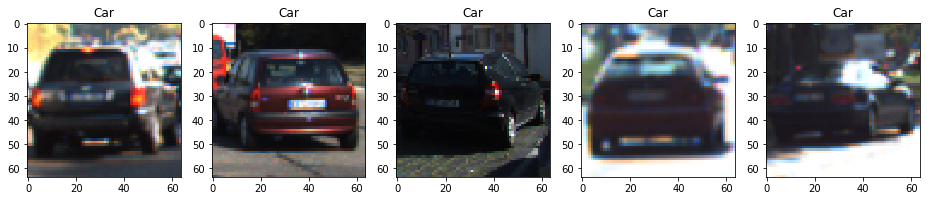

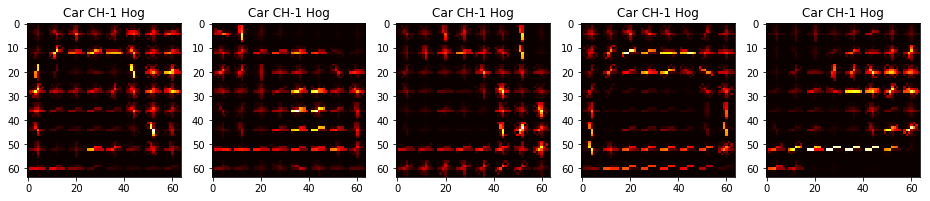

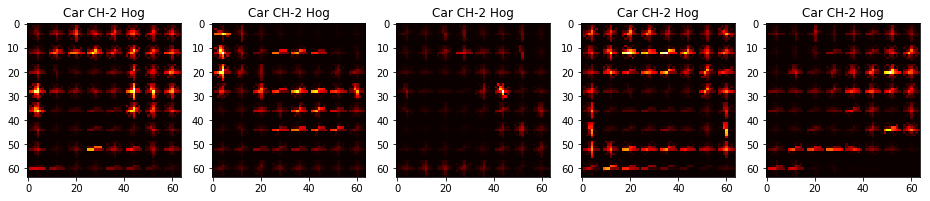

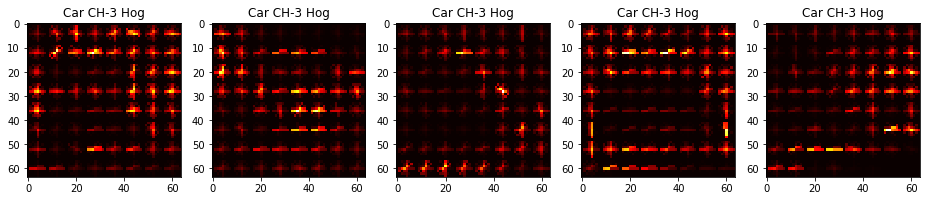

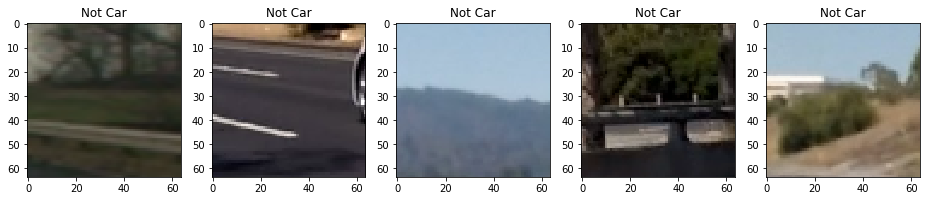

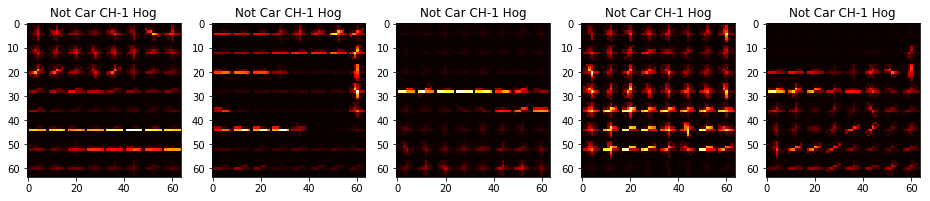

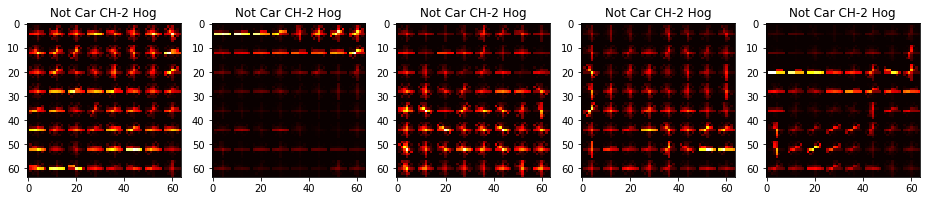

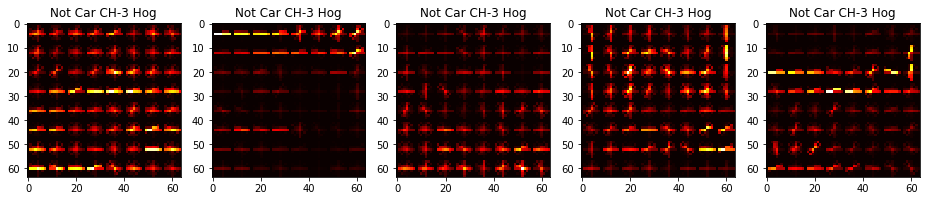

In [6]:


car_samples = random.choice(cars, 5)
notcar_samples = random.choice(notcars, 5)
car_hogs_c1 = []
car_hogs_c2 = []
car_hogs_c3 = []
notcar_hogs_c1 = []
notcar_hogs_c2 = []
notcar_hogs_c3 = []

for car_sample in car_samples:    
    car_image = mpimg.imread(car_sample)
    cf ,ch1 = single_img_visualizations(car_image, color_space = color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, hog_channel=0,spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat, vis=True)
    cf ,ch2 = single_img_visualizations(car_image, color_space = color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, hog_channel=1,spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat, vis=True)
    cf ,ch3 = single_img_visualizations(car_image, color_space = color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, hog_channel=2,spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat, vis=True)
    
    car_hogs_c1.append(ch1)
    car_hogs_c2.append(ch2)
    car_hogs_c3.append(ch3)
    
for notcar_sample in notcar_samples:    
    notcar_image = mpimg.imread(notcar_sample)
    cf ,ch1 = single_img_visualizations(notcar_image, color_space = color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, hog_channel=0,spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat, vis=True)
    cf ,ch2 = single_img_visualizations(notcar_image, color_space = color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, hog_channel=1,spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat, vis=True)
    cf ,ch3 = single_img_visualizations(notcar_image, color_space = color_space, spatial_size=spatial_size,hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, hog_channel=2,spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat, vis=True)
    notcar_hogs_c1.append(ch1)
    notcar_hogs_c2.append(ch2)
    notcar_hogs_c3.append(ch3)


fig = plt.figure(figsize=(16,5))
visualize_from_path(fig,1,5, car_samples,'Car')
plt.show()

fig = plt.figure(figsize=(16,5))
visualize_from_img(fig,1,5, car_hogs_c1,'Car CH-1 Hog')
plt.show()

fig = plt.figure(figsize=(16,5))
visualize_from_img(fig,1,5, car_hogs_c2,'Car CH-2 Hog')
plt.show()

fig = plt.figure(figsize=(16,5))
visualize_from_img(fig,1,5, car_hogs_c3,'Car CH-3 Hog')
plt.show()

fig = plt.figure(figsize=(16,5))
visualize_from_path(fig,1,5, notcar_samples,'Not Car')
plt.show()

fig = plt.figure(figsize=(16,5))
visualize_from_img(fig,1,5, notcar_hogs_c1,'Not Car CH-1 Hog')
plt.show()

fig = plt.figure(figsize=(16,5))
visualize_from_img(fig,1,5, notcar_hogs_c2,'Not Car CH-2 Hog')
plt.show()

fig = plt.figure(figsize=(16,5))
visualize_from_img(fig,1,5, notcar_hogs_c3,'Not Car CH-3 Hog')
plt.show()



In [45]:
def locate_cars_boxes(source_image):
    scale = 1.5    
    out_image, out_box_list = find_cars(source_image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    draw_img = draw_boxes(np.copy(source_image), out_box_list, color=(0, 0, 255), thick=4)   
    return draw_img

def process_image_simple(image):    
    out_img = locate_cars_boxes(image, svc, X_scaler, y_start_stop, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return out_img

def visualize_locate_cars(source_image):
    imgs = []
    scale = 1.5    
    out_image, out_box_list = find_cars(source_image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #imgs.append(out_image)
    draw_img = draw_boxes(np.copy(source_image), out_box_list, color=(0, 0, 255), thick=4)   
    imgs.append(draw_img)
    heatmap = get_heatmap(out_image, out_box_list)
    imgs.append(heatmap)
    labels = label(heatmap)
    #imgs.append(labels)
    draw_img = draw_labeled_bboxes(np.copy(source_image), labels)
    imgs.append(draw_img)
    return imgs

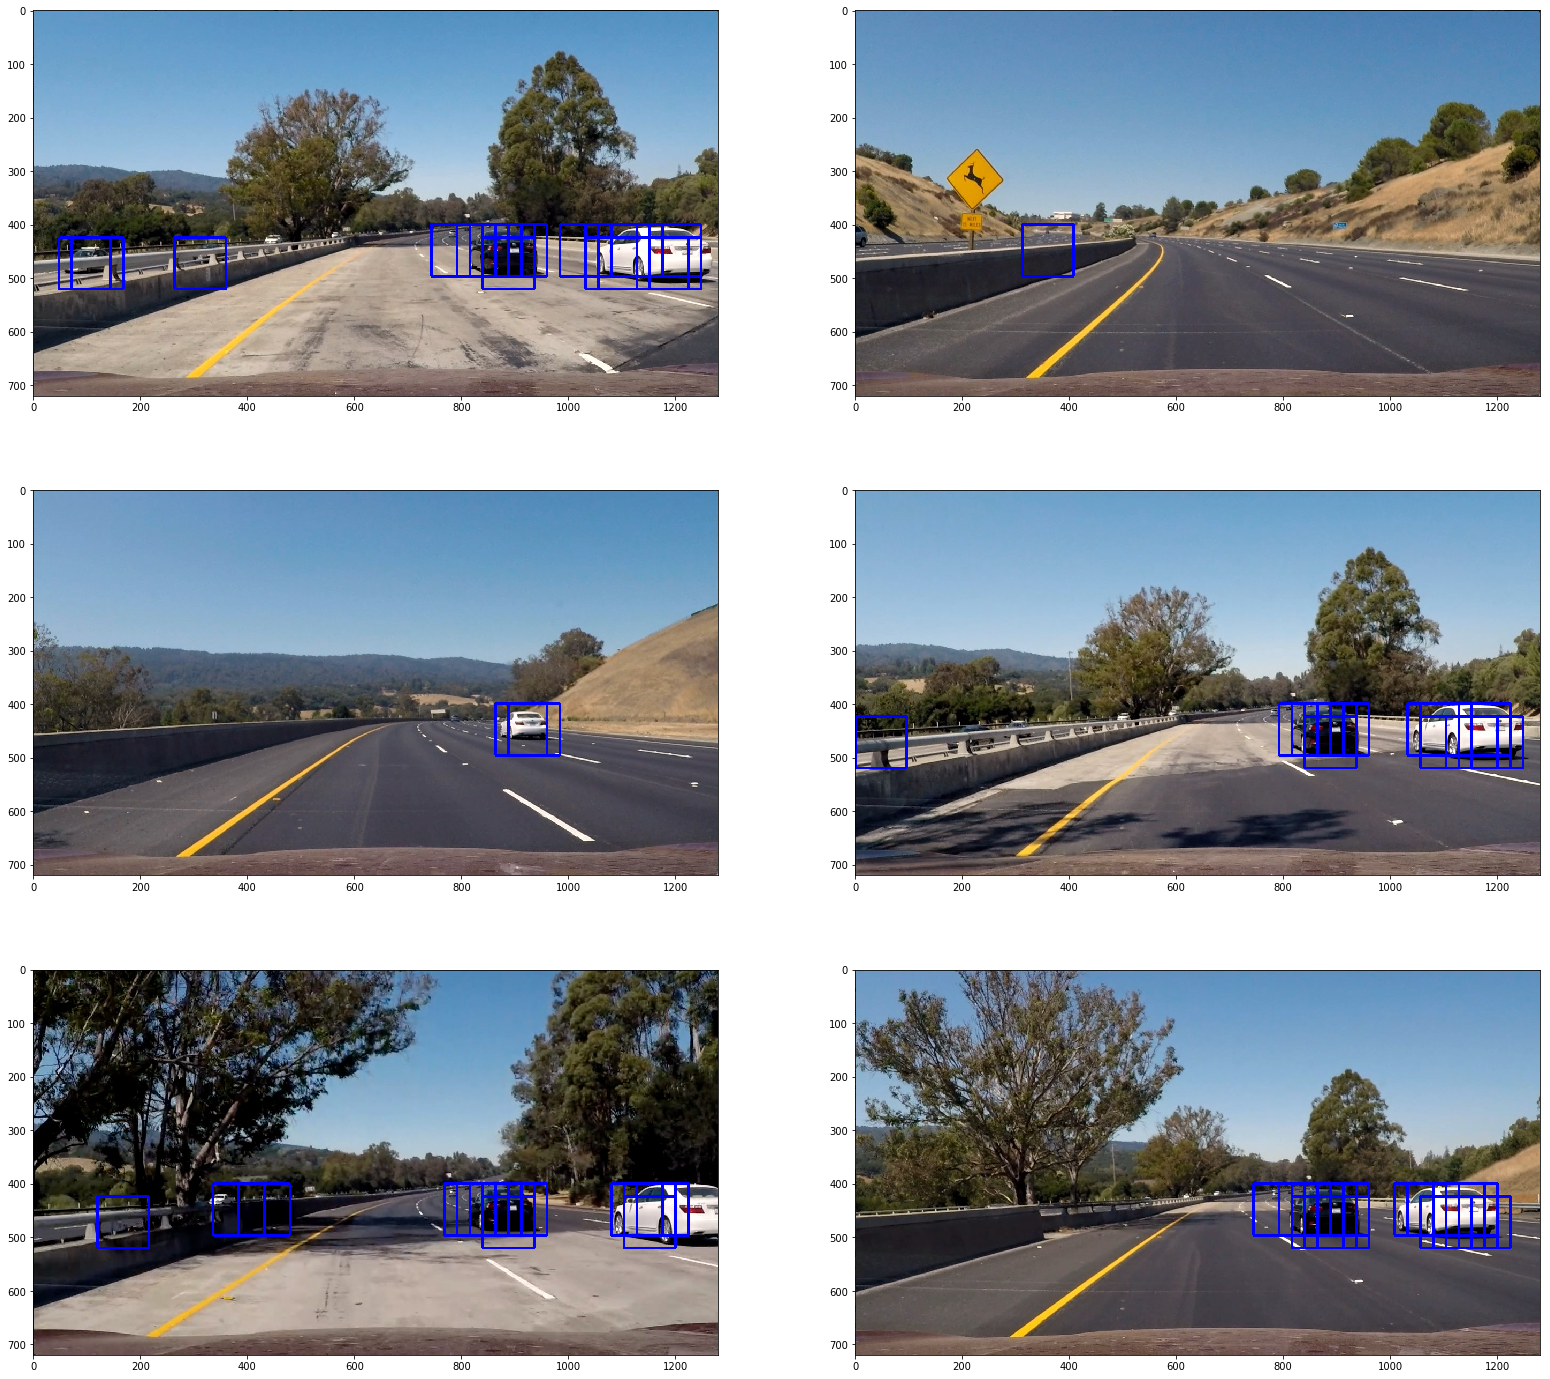

In [46]:
model_data = pickle.load(open( "P5_model.p", "rb" ))
svc, score, X_scaler = model_data[0], model_data[1], model_data[2]


images = glob.glob('test_images/*.jpg')
boxes = []

for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    boxes.append(locate_cars_boxes(img))
    
fig = plt.figure(figsize=(27,25))
visualize_from_img(fig,3,2, boxes,'')
plt.show()


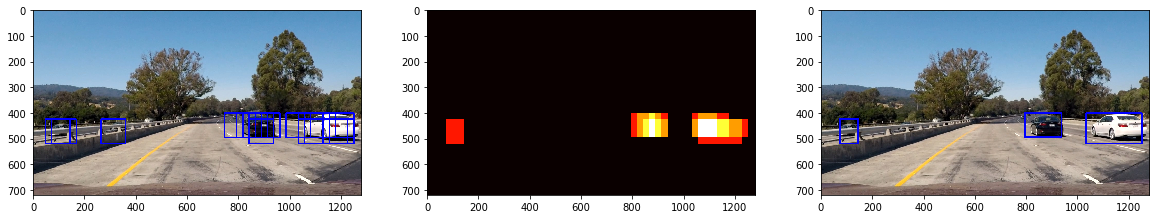

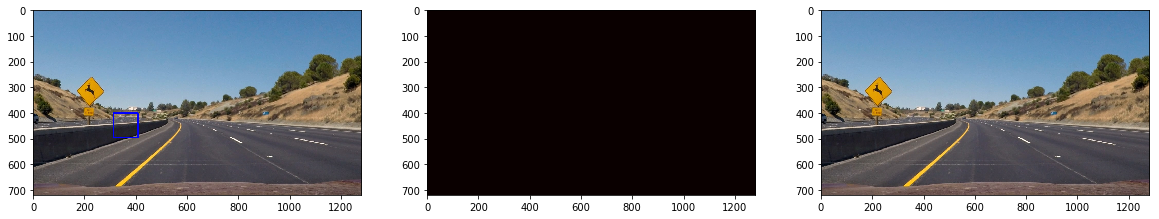

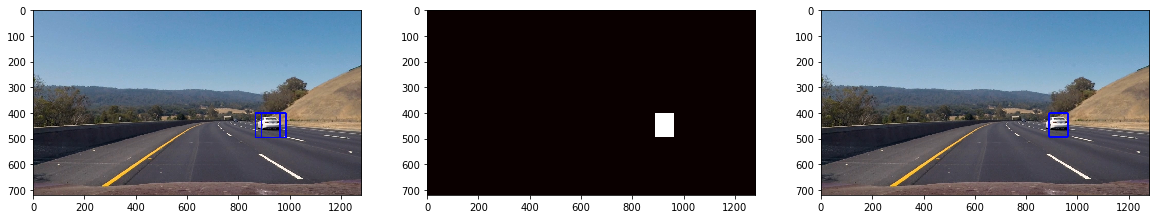

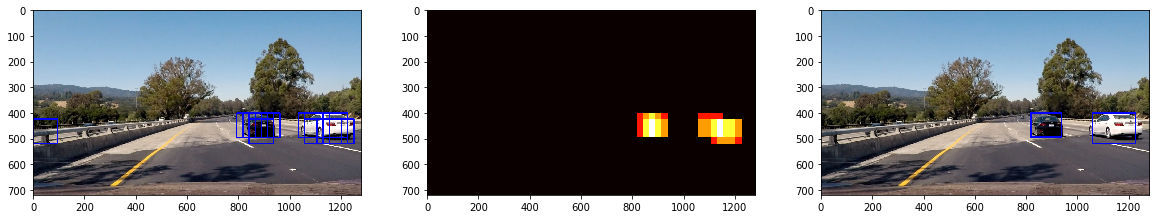

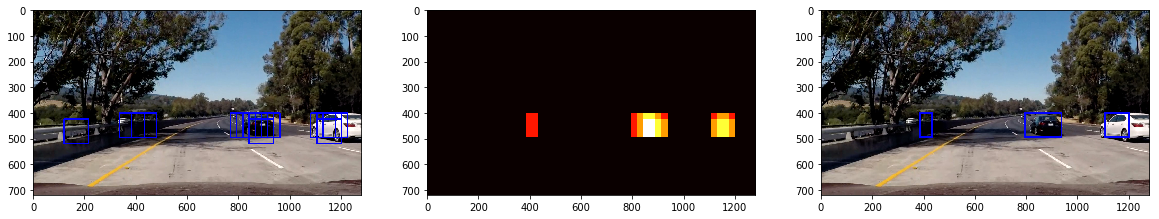

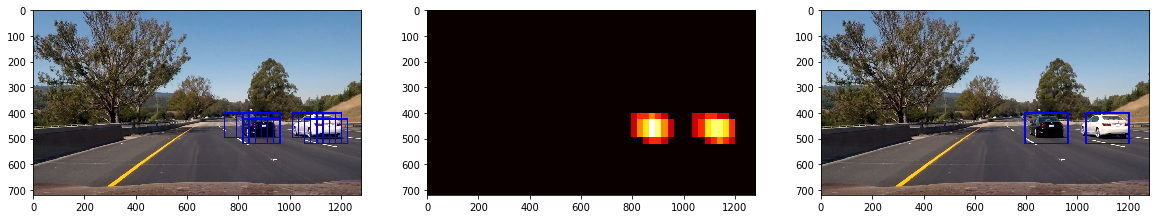

In [55]:
images = glob.glob('test_images/*.jpg')
boxes = []

for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    imgs = visualize_locate_cars(img)
    fig = plt.figure(figsize=(20,75))
    visualize_from_img(fig,18,3, imgs,'')
    plt.show()
    

